# Dask on the IP2I Slurm Farm

## Creating the Dask Cluster on the SLURM Farm

Create the cluster: 

In [1]:
from dask_jobqueue import SLURMCluster

/home/cms/cbernet/miniconda3/envs/dask2/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Don't worry about the FutureWarning, if any. 

In [2]:
cluster = SLURMCluster(
    # queue='normal',
    project="cms",
    cores=2,
    memory="8 GB", 
    walltime="01:00:00",
)

Under the hood, this creates the slurm batch script to spawn a dask cluster on the slurm farm. We can check this script like this: 

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A cms
#SBATCH -n 1
#SBATCH --cpus-per-task=2
#SBATCH --mem=8G
#SBATCH -t 01:00:00

/home/cms/cbernet/miniconda3/envs/dask2/bin/python -m distributed.cli.dask_worker tcp://134.158.83.175:44412 --nthreads 1 --nprocs 2 --memory-limit 3.73GiB --name dummy-name --nanny --death-timeout 60 --protocol tcp://



Note the following:

I used the cms group, which corresponds to my account (cbernet). Make sure to use the group you belong to. You can check it using the `groups` linux command. 

I reserved for each slurm worker: 

* 2 cpus. The two CPUs allow you to run two parallel dask operations at the same time. So if you scale your cluster to 10 workers, you can run 20 dask operations at the same time. 
* 8 GB of memory
* 1 hour. After 1 hour, the worker will be killed by Slurm. In production, I suggest to choose a much longer wall time, say 10 hours so that you can work during the full day. Please make sure not to leave your cluster running if you don't use it, as each worker occupies one slot on the farm. 




We can now scale the cluster to 10 workers. This submits the worker jobs on the slurm farm: 

In [4]:
cluster.scale(jobs=10) 

In your terminal, check your jobs: 

```
squeue -u $USER
```

```
JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
538279    normal dask-wor  cbernet  R       1:38      1 lyowork001
538280    normal dask-wor  cbernet  R       1:38      1 lyowork001
538281    normal dask-wor  cbernet  R       1:38      1 lyowork001
538282    normal dask-wor  cbernet  R       1:38      1 lyowork001
538283    normal dask-wor  cbernet  R       1:38      1 lyowork001
538284    normal dask-wor  cbernet  R       1:38      1 lyowork001
538285    normal dask-wor  cbernet  R       1:38      1 lyowork012
538286    normal dask-wor  cbernet  R       1:38      1 lyowork012
538287    normal dask-wor  cbernet  R       1:38      1 lyowork012
538288    normal dask-wor  cbernet  R       1:38      1 lyowork012
```

The workers are all running and are ready to accept dask tasks. 

The normal queue has been correctly selected according to my walltime of 1h. 

**Dashboard**

Dask comes with a useful dashboard that makes it possible to monitor the performance of your cluster during processing. Get a link to the dashboard like this:

In [5]:
cluster.dashboard_link

'http://134.158.83.175:8787/status'

The dashboard is a web application running on port 8787 of the current machine. To access it, you need to be able to reach this port. If you're outside the lab, you can open an ssh tunnel from your machine to this port through the `lyoserv` portal: 

```
ssh -L 8888:lyoui1:8901 -L 8787:lyoui1:8787 lyoserv 
```

Here, I mapped: 

* port 8787 on my local machine outside the lab to port 8787 of the lyoui1 machine, which I'm using now. 
* port 8888 on my local machine to port 8901 on lyoui1. This is the port on which I run the jupyter notebook server that I'm using now. 

In this way I can access:

* [http://localhost:8787](http://localhost:8787) : the dask cluster dashboard
* [http://localhost:8901](http://localhost:8901) : the jupyter notebook server 

If one of these ports are busy, simply choose another one above 1000. 

## Simple dask processing 

To start with, let's try again to run dask on the local lyoui machine. This is exactly what you did in the dask tutorial: 

In [14]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [15]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)


CPU times: user 64.7 ms, sys: 11.4 ms, total: 76.1 ms
Wall time: 3 s


In [16]:
from dask import delayed

In [17]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)


CPU times: user 909 µs, sys: 782 µs, total: 1.69 ms
Wall time: 934 µs


This was immediate, because we didn't compute anything at this stage, we only declared what we want to do.

In [18]:
z

Delayed('add-7569637e-9b19-4094-9e85-84a9e9bb0592')

Fontconfig warning: ignoring UTF-8: not a valid region tag


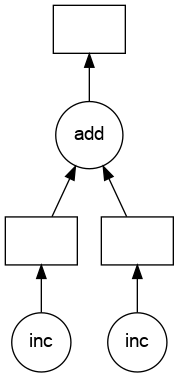

In [19]:
z.visualize()

In [20]:
%%time

z.compute()

CPU times: user 39.2 ms, sys: 13.4 ms, total: 52.6 ms
Wall time: 2 s


5

This time, with dask, the processing took 2s instead of 3s: 

* 1s for the two `inc` operations in parallel
* 1s to `add` 

## Dask distributed

Now let's see how to run these tasks on our cluster. 

First, we create a client, which will allow us to schedule tasks on our cluster: 


In [21]:
from dask.distributed import Client
client = Client(cluster)

And we redefine our functions, this time with a much longer sleep, to give us time to check what's going on during processing:

In [22]:
from time import sleep

def inc(x):
    sleep(10)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We create an input list of values that we are going to increment: 

In [23]:
x = range(10)
x

range(0, 10)

And we increment each value of x: 

In [24]:
incremented = client.map(inc, x)
incremented

[<Future: pending, key: inc-0fb8376a9753b78dfbfbfdd70db76fe0>,
 <Future: pending, key: inc-45022c3e2a0468222bd5d76fa5b305fa>,
 <Future: pending, key: inc-aa21f932c92b8321bc6c1ab1833fa645>,
 <Future: pending, key: inc-8937219d80df50a7044e0b7bb8b09dc4>,
 <Future: pending, key: inc-03abfe468be63aa360680991a1a659c9>,
 <Future: pending, key: inc-9c246b4e3cc07213aefd0e7d1cfdb3e2>,
 <Future: pending, key: inc-45ffefd96a7d4fd62bac6c0976cc2d6b>,
 <Future: pending, key: inc-7c2fb1fdd2f7cd94a2d27d59cd98f2fa>,
 <Future: pending, key: inc-4b8f8fd957710d5da749d50ce9218603>,
 <Future: pending, key: inc-7012a97e66f0e973e5cb251a8297edb5>]

Dask submitted 10 parallel tasks, that are currently running (the result is pending).
Execute the following command repeatedly until you see that theses tasks are finished. 

In [28]:
incremented

[<Future: finished, type: int, key: inc-0fb8376a9753b78dfbfbfdd70db76fe0>,
 <Future: finished, type: int, key: inc-45022c3e2a0468222bd5d76fa5b305fa>,
 <Future: finished, type: int, key: inc-aa21f932c92b8321bc6c1ab1833fa645>,
 <Future: finished, type: int, key: inc-8937219d80df50a7044e0b7bb8b09dc4>,
 <Future: finished, type: int, key: inc-03abfe468be63aa360680991a1a659c9>,
 <Future: finished, type: int, key: inc-9c246b4e3cc07213aefd0e7d1cfdb3e2>,
 <Future: finished, type: int, key: inc-45ffefd96a7d4fd62bac6c0976cc2d6b>,
 <Future: finished, type: int, key: inc-7c2fb1fdd2f7cd94a2d27d59cd98f2fa>,
 <Future: finished, type: int, key: inc-4b8f8fd957710d5da749d50ce9218603>,
 <Future: finished, type: int, key: inc-7012a97e66f0e973e5cb251a8297edb5>]

Then gather the results: 

In [29]:
client.gather(incremented)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Check your dashboard: http://localhost:8787 

You should see that your cluster ran `inc` 10 times in parallel.

Now try again: 

In [30]:
incremented = client.map(inc, x)
incremented

[<Future: finished, type: int, key: inc-0fb8376a9753b78dfbfbfdd70db76fe0>,
 <Future: finished, type: int, key: inc-45022c3e2a0468222bd5d76fa5b305fa>,
 <Future: finished, type: int, key: inc-aa21f932c92b8321bc6c1ab1833fa645>,
 <Future: finished, type: int, key: inc-8937219d80df50a7044e0b7bb8b09dc4>,
 <Future: finished, type: int, key: inc-03abfe468be63aa360680991a1a659c9>,
 <Future: finished, type: int, key: inc-9c246b4e3cc07213aefd0e7d1cfdb3e2>,
 <Future: finished, type: int, key: inc-45ffefd96a7d4fd62bac6c0976cc2d6b>,
 <Future: finished, type: int, key: inc-7c2fb1fdd2f7cd94a2d27d59cd98f2fa>,
 <Future: finished, type: int, key: inc-4b8f8fd957710d5da749d50ce9218603>,
 <Future: finished, type: int, key: inc-7012a97e66f0e973e5cb251a8297edb5>]

This time, the tasks enter the finished state immediately, no need to wait for 10s. 

This is because Dask is clever enough to track past operations and to keep the results on the workers. The results of these tasks are already on the workers, and are already available for future processing.

If you want, you can restart your cluster like this:  

In [31]:
client.restart()

<Client: 'tcp://134.158.83.175:44412' processes=0 threads=0, memory=0 B>

Congratulations! 

You have successully run your first jobs on the IP2I Slurm cluster with Dask. 

Now we're going to do do something a bit more ambitious, with fairly big text data. For now, close your cluster: 

In [32]:
cluster.close()